In [83]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn import datasets
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabaz_score
from sklearn import metrics
from scipy.cluster.hierarchy import dendrogram, linkage,fcluster

In [3]:
df_path = "../Outputs/customer_order_train_reduced.csv"
df = pd.read_csv(df_path)
df.drop(df.columns[0], axis=1, inplace=True)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,61,62,63,64,65,66,67,68,69,70
0,-5.910101,-1.817756,-3.132463,-0.107840,2.262797,-1.085222,-0.343117,1.695994,0.221188,-0.033039,...,-0.272325,0.211194,0.998564,0.661929,-0.246326,-0.339113,0.429339,0.863432,-0.747858,-0.352087
1,-6.179444,-2.108571,-3.644230,0.078246,4.048101,-1.165402,1.540327,-0.342280,-0.159625,-0.925080,...,0.326506,0.172667,-1.231313,-0.543753,0.244803,0.049766,-0.890263,1.930898,0.833700,1.178497
2,175.175162,-2.025396,-0.748486,1.191982,5.387377,3.564970,-5.178943,-5.159448,-2.580185,0.534896,...,1.137074,-0.716124,1.016299,3.055268,-0.415043,-0.712064,1.742104,0.337453,0.706408,6.483967
3,-5.815371,0.090122,-1.756488,-0.347117,-2.340362,-8.403755,4.236185,0.557626,-1.000335,-1.694324,...,-1.059698,1.697802,0.728849,-0.816363,0.541905,0.731675,0.402328,-0.866669,0.615065,-0.552924
4,-6.094946,-1.132857,-2.957879,0.130307,2.361835,-3.727978,1.167230,-3.244399,-0.304043,-0.437521,...,-0.171043,-0.366000,-0.145396,0.473588,0.183927,-0.220939,0.381579,-0.700740,0.339453,0.065392


In order to compare with K-mean and DBSCAN, we choose cluster number equals to 5 for this one.

In addition, since we need to group-up the datapoints instead of divide them, we will choose 'Agglomerative Clustering' approach.

Within 'Agglomerative Clustering' we have several methods*, which are slightly different in rules in regards of how we group the datapoints and how to differentiate each group.

*method:
    1. Single Linkage. In single linkage hierarchical clustering, the distance between two clusters is defined as the shortest distance between two points in each cluster. For example, the distance between clusters “r” and “s” to the left is equal to the length of the arrow between their two closest points.
    2. Complete Linkage. In complete linkage hierarchical clustering, the distance between two clusters is defined as the longest distance between two points in each cluster. For example, the distance between clusters “r” and “s” to the left is equal to the length of the arrow between their two furthest points.
    3. Average Linkage. In average linkage hierarchical clustering, the distance between two clusters is defined as the average distance between each point in one cluster to every point in the other cluster. For example, the distance between clusters “r” and “s” to the left is equal to the average length each arrow between connecting the points of one cluster to the other.
    4. Ward Method. Ward’s method says that the distance between two clusters, A and B, is how much the sum of squares will increase when we merge them. (to minimize the std in each cluster)
    

We will try each method below and see if it works.

In [6]:
# Single Linkage
# build the model
ac_model_single = AgglomerativeClustering(n_clusters=5, linkage='single').fit(df)

# print our the number of observations per cluster
for c in np.unique(ac_model_single.labels_):
        print('cluster {}: {}'.format(c, np.sum(ac_model_single.labels_==c)))

cluster 0: 20164
cluster 1: 1
cluster 2: 1
cluster 3: 1
cluster 4: 1


In [4]:
# Complete Linkage
# build the model
ac_model_complete = AgglomerativeClustering(n_clusters=5, linkage='complete').fit(df)

# print our the number of observations per cluster
for c in np.unique(ac_model_complete.labels_):
        print('cluster {}: {}'.format(c, np.sum(ac_model_complete.labels_==c)))

cluster 0: 20046
cluster 1: 17
cluster 2: 2
cluster 3: 22
cluster 4: 81


In [5]:
# Average Linkage
# build the model
ac_model_ave = AgglomerativeClustering(n_clusters=5, linkage='average').fit(df)

# print our the number of observations per cluster
for c in np.unique(ac_model_ave.labels_):
        print('cluster {}: {}'.format(c, np.sum(ac_model_ave.labels_==c)))

cluster 0: 20161
cluster 1: 3
cluster 2: 2
cluster 3: 1
cluster 4: 1


In [7]:
# Ward Method
# build the model
ac_model_ward = AgglomerativeClustering(n_clusters=5, linkage='ward').fit(df)

# print our the number of observations per cluster
for c in np.unique(ac_model_ward.labels_):
        print('cluster {}: {}'.format(c, np.sum(ac_model_ward.labels_==c)))

cluster 0: 18402
cluster 1: 69
cluster 2: 1220
cluster 3: 234
cluster 4: 243


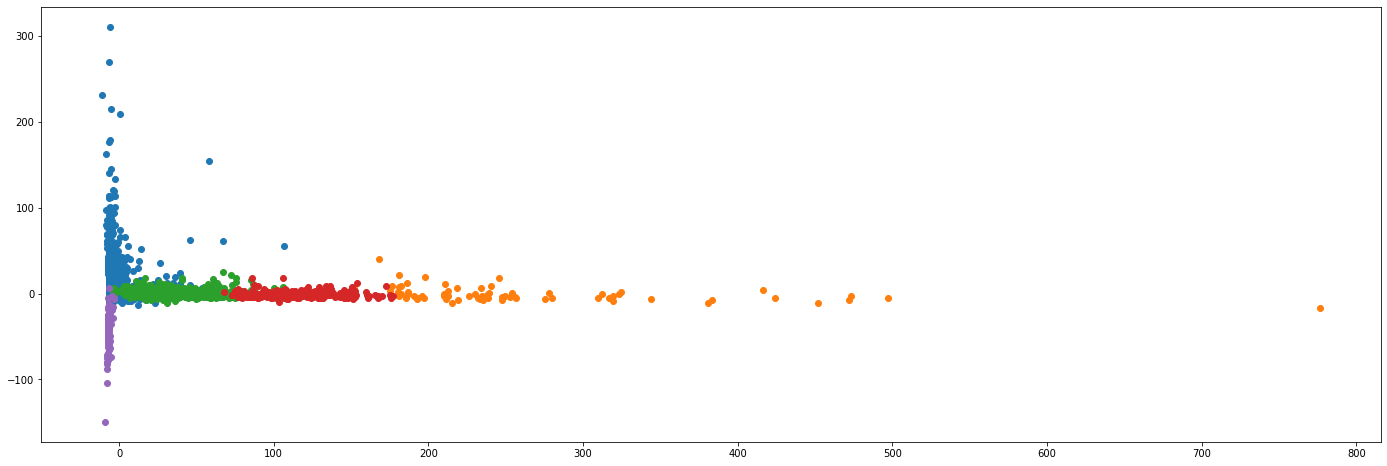

In [82]:
# plot the clusters
n_clusters_ = 5
labels = ac_model_ward.labels_
plt.figure(figsize=(24, 8))
for i in range(n_clusters_):
    one_cluster = X[labels == i]
    plt.plot(one_cluster[:,0],one_cluster[:,1],'o')

plt.show()

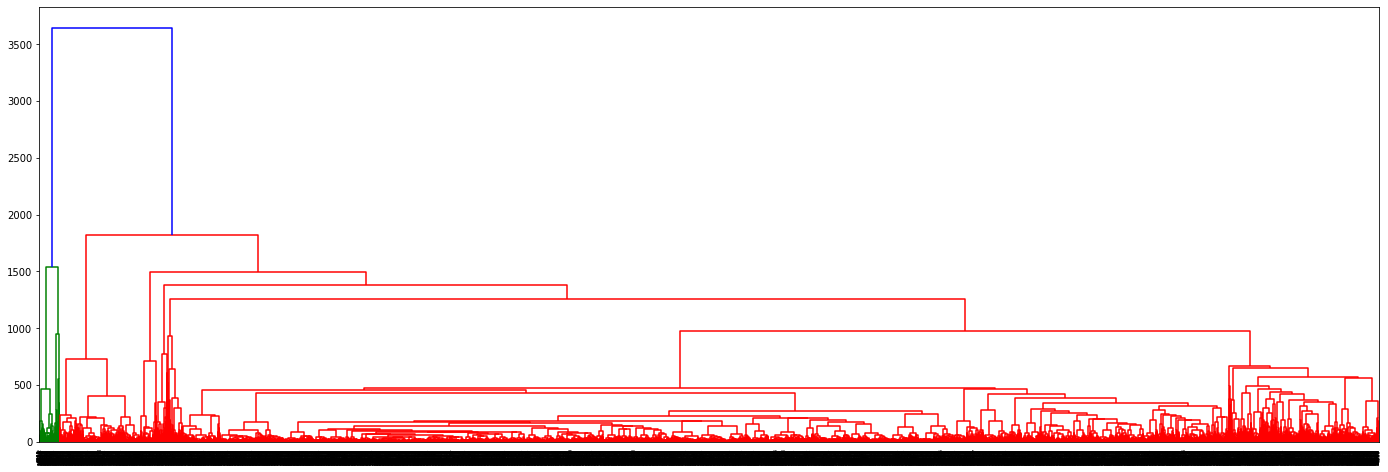

In [32]:
# plot dendrogram
X = df.values
linked = linkage(X, 'ward')

plt.figure(figsize=(24, 8))
dendrogram(linked,
            orientation='top',
            # labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

Over the four methos we use, it looks like that Ward Linkage provide us the best result(instead of having one cluster holds over 99% datapoint, we have several clusters with their cluster size over 100).

Next step, we will use the results from Ward Linkage Method and find out what item(s) fall into each cluster. 

In [13]:
def ac_build_ward(data_train, n_cluster, data_predict):
    # build model
    ac_model_ward = AgglomerativeClustering(n_clusters=5, linkage='ward').fit(data_train)
    
    # predict customer group
    cust_group = ac_model_ward.predict(data_predict)
    
    # print number of customers per cluster
    print('Cluster Group | Total Customer')
    print(pd.Series(cust_group).value_counts())
    
    # save model
    pickle.dump(ac_model_ward, open(f'ac_model_ward_{n_cluster}.sav', 'wb'))
    
    return cust_group

In [33]:
def ac_build_ward_n(data_train, n_cluster, data_predict):
    # build model
    ac_model_ward = AgglomerativeClustering(n_clusters=5, linkage='ward')
    
    # predict customer group
    cust_group = ac_model_ward.fit_predict(data_predict)
    
    # print number of customers per cluster
    print('Cluster Group | Total Customer')
    print(pd.Series(cust_group).value_counts())
    
    # save model
    pickle.dump(ac_model_ward, open(f'ac_model_ward_{n_cluster}.sav', 'wb'))
    
    return cust_group

In [36]:
customer_cluster = ac_build_ward_n(df, 5, df)

Cluster Group | Total Customer
0    18402
2     1220
4      243
3      234
1       69
dtype: int64


In [8]:
# load the original dataset
cust_train = pd.read_csv('../Outputs/customer_order_train.csv', index_col='user_id')
cust_train

,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,international,meat seafood,missing_y,other_y,pantry,personal care,pets,produce,snacks,organic
user_id,,,,,,,,,,,,,,,,,,,,,
19510,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,5,15,0,76,14,152
147319,0,1,0,0,0,1,1,2,0,0,...,3,3,1,0,7,0,0,18,6,23
85028,0,8,0,3,126,0,1,0,0,0,...,11,12,0,1,47,0,0,173,49,68
72168,0,0,0,0,0,0,4,0,0,0,...,2,2,0,0,13,3,0,43,31,93
142535,0,1,0,0,0,0,1,0,0,0,...,3,6,0,0,8,4,0,12,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13607,0,0,0,0,19,0,1,0,0,0,...,2,16,1,0,9,3,0,398,67,519
117498,0,0,0,0,0,0,0,0,0,0,...,0,1,9,0,11,3,1,25,6,60
164881,0,1,0,0,0,0,6,0,0,0,...,1,1,0,0,12,1,0,33,6,11


In [39]:
# feed the cluster back to the dataset 
cust_train['customer type'] = customer_cluster
cust_train.head()

,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,meat seafood,missing_y,other_y,pantry,personal care,pets,produce,snacks,organic,customer type
user_id,,,,,,,,,,,,,,,,,,,,,
19510,0,0,0,0,0,0,0,0,0,0,...,1,0,0,5,15,0,76,14,152,0
147319,0,1,0,0,0,1,1,2,0,0,...,3,1,0,7,0,0,18,6,23,0
85028,0,8,0,3,126,0,1,0,0,0,...,12,0,1,47,0,0,173,49,68,3
72168,0,0,0,0,0,0,4,0,0,0,...,2,0,0,13,3,0,43,31,93,0
142535,0,1,0,0,0,0,1,0,0,0,...,6,0,0,8,4,0,12,5,1,0


In [44]:
df_new = cust_train.groupby('customer type').mean()
df_new

,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,international,meat seafood,missing_y,other_y,pantry,personal care,pets,produce,snacks,organic
customer type,,,,,,,,,,,,,,,,,,,,,
0,0.176285,1.504836,0.050212,0.056081,0.695305,0.291273,2.819422,0.185415,0.048473,0.364417,...,2.441854,6.149658,0.644550,0.296816,16.282415,3.783882,0.998424,82.799804,25.430062,88.274318
1,0.202899,2.666667,1.739130,0.695652,185.869565,0.913043,6.318841,0.449275,0.144928,0.000000,...,4.956522,16.318841,2.652174,0.971014,40.811594,12.405797,0.942029,253.362319,85.405797,458.449275
2,0.081967,2.031148,0.424590,0.300820,26.332787,0.295082,4.152459,0.191803,0.077049,0.070492,...,3.360656,10.074590,0.823770,0.495082,22.756557,4.693443,0.309836,135.137705,35.860656,191.227049
3,0.068376,2.316239,0.474359,0.470085,82.730769,0.337607,5.247863,0.358974,0.072650,0.025641,...,4.282051,11.888889,1.918803,0.482906,29.337607,7.311966,0.525641,179.606838,47.414530,288.269231
4,0.004115,0.201646,0.000000,0.000000,0.000000,0.374486,1.275720,0.234568,0.012346,0.152263,...,0.238683,3.016461,0.098765,0.127572,10.061728,0.909465,0.053498,151.662551,23.872428,56.176955


In [60]:
#cluster 0
cluster_0 = df_new.loc[[0]]
cluster_0 = cluster_0.sort_values(by=0, ascending=False, axis=1)
# cluster_0 
cluster_0 .loc[:, cluster_0 .columns != "Total"]

,Total,organic,produce,dairy eggs,fresh fruits,fresh vegetables,snacks,beverages,frozen,pantry,...,facial care,first aid,specialty wines champagnes,shave needs,kitchen supplies,eye ear care,baby bath body care,baby accessories,beauty,frozen juice
customer type,,,,,,,,,,,,,,,,,,,,,
0,279.679002,88.274318,82.799804,47.021628,31.631888,31.082763,25.430062,23.245843,19.522389,16.282415,...,0.093631,0.08385,0.080752,0.078633,0.06934,0.066134,0.056081,0.050212,0.048473,0.039344


In [67]:
#cluster 1
cluster_1 = df_new.loc[[1]]
cluster_1 = cluster_1.sort_values(by=1, ascending=False, axis=1)
# cluster_1 
cluster_1 .loc[:, cluster_1 .columns != "Total"]

,organic,produce,babies,baby food formula,dairy eggs,fresh fruits,fresh vegetables,snacks,beverages,frozen,...,ice cream toppings,bulk grains rice dried goods,eye ear care,frozen juice,spirits,specialty wines champagnes,alcohol,red wines,white wines,beers coolers
customer type,,,,,,,,,,,,,,,,,,,,,
1,458.449275,253.362319,191.652174,185.869565,143.333333,112.144928,86.318841,85.405797,65.594203,58.782609,...,0.086957,0.086957,0.086957,0.028986,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
#cluster 2
cluster_2 = df_new.loc[[2]]
cluster_2 = cluster_2.sort_values(by=2, ascending=False, axis=1)
# cluster_2 
cluster_2 .loc[:, cluster_2 .columns != "Total"]

,organic,produce,dairy eggs,fresh fruits,fresh vegetables,snacks,frozen,babies,baby food formula,packaged vegetables fruits,...,first aid,ice cream toppings,air fresheners candles,eye ear care,kitchen supplies,beauty,beers coolers,specialty wines champagnes,frozen juice,spirits
customer type,,,,,,,,,,,,,,,,,,,,,
2,191.227049,135.137705,83.715574,56.679508,46.390164,35.860656,31.036885,28.27623,26.332787,26.295082,...,0.098361,0.096721,0.081967,0.080328,0.078689,0.077049,0.070492,0.055738,0.038525,0.027869


In [69]:
#cluster 3
cluster_3 = df_new.loc[[3]]
cluster_3 = cluster_3.sort_values(by=3, ascending=False, axis=1)
# cluster_3 
cluster_3 .loc[:, cluster_3 .columns != "Total"]

,organic,produce,dairy eggs,babies,baby food formula,fresh fruits,fresh vegetables,snacks,frozen,beverages,...,frozen juice,beauty,air fresheners candles,red wines,cocoa drink mixes,kitchen supplies,beers coolers,specialty wines champagnes,white wines,spirits
customer type,,,,,,,,,,,,,,,,,,,,,
3,288.269231,179.606838,116.209402,84.649573,82.730769,78.440171,59.782051,47.41453,40.628205,36.615385,...,0.089744,0.07265,0.068376,0.047009,0.042735,0.029915,0.025641,0.012821,0.008547,0.0


In [70]:
#cluster 4
cluster_4 = df_new.loc[[4]]
cluster_4 = cluster_4.sort_values(by=4, ascending=False, axis=1)
# cluster_4 
cluster_4 .loc[:, cluster_4 .columns != "Total"]

,produce,packaged produce,organic,fresh fruits,dairy eggs,snacks,beverages,packaged vegetables fruits,fresh vegetables,frozen,...,kosher foods,seafood counter,air fresheners candles,deodorants,cat food care,bulk grains rice dried goods,shave needs,baby food formula,baby bath body care,baby accessories
customer type,,,,,,,,,,,,,,,,,,,,,
4,151.662551,69.090535,56.176955,50.588477,30.674897,23.872428,19.99177,17.374486,14.300412,10.218107,...,0.004115,0.004115,0.004115,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:

# function to plot purchase pattern heat map
# `order_history`: order history data (unscaled, non-dimension-reduction)
# `plot_threshold`: percent of purchase for a product category to not display in heat map (0.02 = 2%)
#                   [reduce number of categories to plot]
def customer_group_heatmap(order_history, plot_threshold=0.02):
    # 1) convert number of purchase to percent
    # aisle categories
    order_history.iloc[:,0:134] = order_history.iloc[:,0:134].div(order_history.Total, axis=0)
    # department categories
    order_history.iloc[:,135:156] = order_history.iloc[:,135:156].div(order_history.Total, axis=0)
    # organic product
    order_history.iloc[:,156] = order_history.iloc[:,156].div(order_history.Total, axis=0)
    #     print('First 10 records')
    #     print(order_history.head())
    
    # 2) average by customer group
    cg_order_history = order_history.groupby('customer type').mean()
    #     print('-------')
    #     print(cg_order_history)
    
    cg_aisle = cg_order_history.iloc[:,0:134]
    cg_dept = cg_order_history.iloc[:,135:157]
    cg_total = cg_order_history.iloc[:,[134]]
    
    #3) threshold for a product category to display in heatmap
    cg_aisle = cg_aisle.loc[:,(cg_aisle>plot_threshold).any()]
    cg_dept = cg_dept.loc[:,(cg_dept>plot_threshold).any()]
    
    #4) plot heat map
    fig = plt.figure(figsize=(10,12))
    gridspec.GridSpec(5,1)

    # Top map: Average percent of products by aisle bought by customer cluster
    plt.subplot2grid((9,1), (0,0), rowspan=4)
    plt.title('Percent of Items Purchased by Customer Type (Aisle)')
    sns.heatmap(cg_aisle.transpose(), cmap="Blues", linewidths=0.1)
    
    # Middle map: Average percent of products by department bought by customer cluster
    plt.subplot2grid((9,1), (4,0), colspan=1, rowspan=4)
    plt.title('Percent of Items Purchased by Customer Type (Department)')
    sns.heatmap(cg_dept.transpose(), cmap="Blues", linewidths=0.1)

    # Bottom map: Avearage number of products purchased
    plt.subplot2grid((9,1), (8,0))
    plt.title('Average # of Items Purchased by Customer Type')
    sns.heatmap(cg_total.transpose(), cmap="Reds", annot=True, fmt='0g', linewidths=0.2)

    plt.tight_layout()
    plt.show()